In [14]:
from ecell4 import *
from ecell4.extra import ensemble
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

simrun=70#000
duration = 3000
#rm = 0.005
D=0.1
nproc=None
L=2#cbrt(10)
k0= 0.1
method='multiprocessing'

for rm in [0.05]:
    def write(name,obs):
        try:
            f=open(name,'w')
            data = np.array(obs.data()).T
            np.savetxt(name,np.column_stack([data[0],data[1]]),delimiter=',',fmt='%s')
            f.close()        
            print('saving into',name)        
            e=open(name+'_err','w')        
            err = np.array(obs.error()).T        
            np.savetxt(name+'_err',np.column_stack([err[0],err[1]]),delimiter=',',fmt='%s')
            e.close()
            print('saving into',name+'_err')
        except AttributeError:
            print('no error')



    def singlerun(solver='ode',intrinsic=False,simrun=1):   
        print(solver)
        V = L**3 
        M = max(int(min(cbrt(Nas), L / (2 * rm))), 3)
        if solver=='spa':
            solver=("spatiocyte",rm)
            V=spatiocyte.SpatiocyteWorld.calculate_volume(Real3(L,L,L),rm)
        elif solver=='egfrd':
            solver = ('egfrd', Integer3(M, M, M)) 

        kon=k0/V       
        Ca=5
        keff = kon*V/Ca
        kd = 4*np.pi*rm*2*D*2
        ka = keff*kd/(kd-keff)
        assert(ka>0)
        with species_attributes():
            A | {'D': D, 'radius':rm}
            B | {'D': D, 'radius':rm}

        with reaction_rules():
            ~A > A | kon
            A + B >B | (ka if intrinsic else keff)
        m = get_model()

        print('av={:.3},intrinsic={}'.format(float(V),intrinsic))
        print('kon={:.3},koff={:.3},kd={:.3},keff={:.3},kfactor={:.3}'.format(kon,(ka if intrinsic else keff),kd,keff,ka/kd))
        if simrun >1    :
            obs=ensemble.ensemble_simulations(duration,n=simrun, y0={'B':1},model=m, solver=solver,volume=ones()*L,species_list=["A"],return_type='observer',nproc=nproc,method=method)#,return_type="observer")
        else:
            obs=run_simulation(duration,model=m,y0={'B':1},return_type='observer',species_list=['A'],solver=solver,volume=ones()*L)
        return obs

    obs1=singlerun('ode',False,1)
    #obs2=singlerun('spa',True,simrun)
    obs3=singlerun('egfrd',True,simrun)
    #obs4=singlerun('gillespie',False,simrun)
    #write('/home/chew/outputdata/sturrock_bd_ode_rm{:.3}_Nas5'.format(rm),obs1)
    #write('/home/chew/outputdata/sturrock_bd_spa_rm{:.3}_Nas5_10k'.format(rm),obs2)
    #write('/home/chew/outputdata/sturrock_bd_egfrd_rm{:.3}_Nas5_10k'.format(rm),obs3)

ode
av=8.0,intrinsic=False
kon=0.0125,koff=0.02,kd=0.251,keff=0.02,kfactor=0.0865
egfrd
av=8.0,intrinsic=True
kon=0.0125,koff=0.0217,kd=0.251,keff=0.02,kfactor=0.0865


In [20]:
write('/home/chew/outputdata/sturrock_bd_egfrd_rm{:.3}_Ca5_L2_Nb1'.format(rm),obs3)

saving into /home/chew/outputdata/sturrock_bd_egfrd_rm0.05_Ca5_L2_Nb1
saving into /home/chew/outputdata/sturrock_bd_egfrd_rm0.05_Ca5_L2_Nb1_err


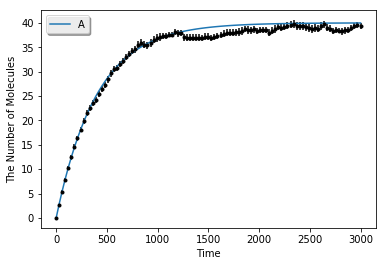

In [16]:
viz.plot_number_observer(obs1,'r-',obs3,'k.')
#print(obs4.data().T[1][-1])
#viz.plot_number_observer(obs2,'r.',obs1,'k-')#,obs3,'k-')

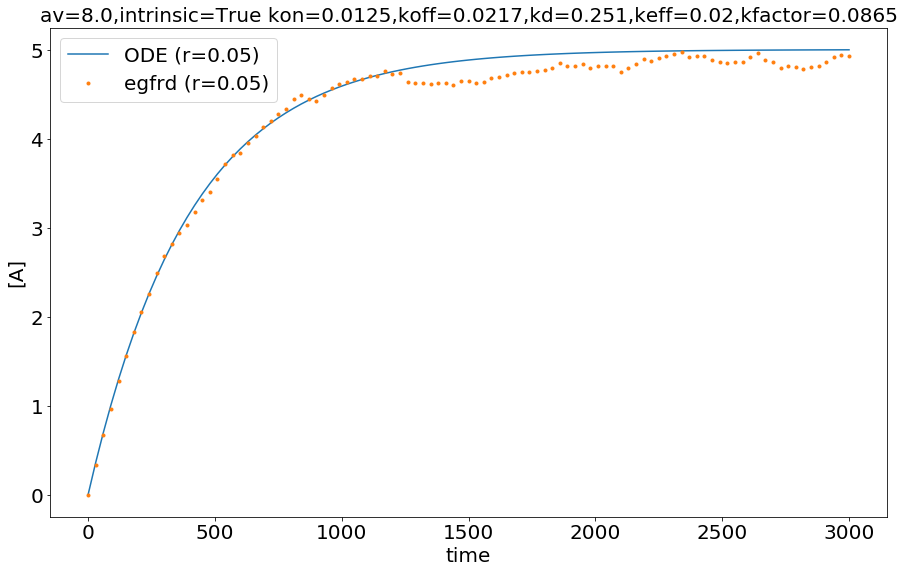

In [22]:
fig=plt.figure()
data1 = np.array(obs1.data()).T
plt.plot(data1[0], data1[1]/8,'-', label='ODE (r={})'.format(rm))
data3 = np.array(obs3.data()).T
err3 = np.array(obs3.error()).T
plt.plot(data3[0], data3[1]/8,'.', label='egfrd (r={})'.format(rm))
plt.legend(loc='best',fontsize=20)
fig.set_size_inches(15, 9)
plt.tick_params(labelsize=20)
s=20
plt.xlabel('time',fontsize=s)
plt.ylabel('[A]',fontsize=s)
#plt.title('L={},D={},kd={:3},keff={:3},ka_Spa={:3},ka_eGFRD={:3}'.format(L,D,0.126,0.02,0.025,0.024),fontsize=s)
plt.title('av=8.0,intrinsic=True kon=0.0125,koff=0.0217,kd=0.251,keff=0.02,kfactor=0.0865',fontsize=s)
#plt.savefig('/home/chew/ecellwork/figure/sturrock_birth_death_rm0.005_Nas10.png')